In [1]:
import os  # for saving files
import numpy as np
from matplotlib import pyplot as plt

# from muvi import geometry as geo

import vorpy as vp  # This can take ~20s for CUDA method to load


  Activating project at `~/Dropbox/code/vorpy`


Max number of thread: 640
Register usage: 96
Memory usage: (local = 280, shared = 0, constant = 0)


In [2]:
odir = 'vrtx_ring_fps'
if not os.path.exists(odir):
    os.makedirs(odir)

In [3]:
#############################################
# Generate a vortex (points, core radii, and
# circulation).
#############################################

NUMSEGS = 100
RINGRADIUS = 10

# Generate the vortex points
# x = r * cos(theta)
# y = r * sin(theta)
theta = np.linspace(0, 2 * np.pi, NUMSEGS)
vpx = RINGRADIUS * np.cos(theta)
vpy = RINGRADIUS * np.sin(theta)
vpz = np.zeros_like(vpx)
vpps = np.concatenate([vpx[:, np.newaxis], vpy[:, np.newaxis], vpz[:, np.newaxis]], axis=1)
# To prevent numerical errors, explicitly set
# the last point to the the first.
vpps[-1] = vpps[0]

# Generate the core radii
vcrds = np.ones(NUMSEGS+1) * 1.0

# Generate the circulation
vcirs = np.ones(NUMSEGS+1) * 1.0

In [4]:
# Boundary function takes a point and returns
# true if the point is inside the boundary
# The boundary functions are then used in the
# loop for deleting points where they are used
# to check if given point is inside the given
# boundary.

def far_field_boundary(x, y, z):
    xshf = x - 10
    yshf = y - 10
    zshf = z - 10
    return (xshf**2 + yshf**2) > 6**2 and 9 <= zshf <= 11

def ring_boundary(x, y, z):
    xshf = x - 10
    yshf = y - 10
    zshf = z - 10

    def outer_ring(x, y):
        return (x**2 + y**2) <= 6**2 

    def inner_ring(x, y):
        return (x**2 + y**2) >= 4**2
    
    return outer_ring(xshf, yshf) and inner_ring(xshf, yshf) and 9 <= zshf <= 11

def ring_center_boundary(x, y, z):
    xshf = x - 10
    yshf = y - 10
    zshf = z - 10
    return (xshf**2 + yshf**2) < 4**2 and 9 <= zshf <= 11

# https://en.wikipedia.org/wiki/Torus
# Let R be the distance from the center of the tube
# to the center of the torus (i.e., the major radius),
# and r be the radius of the tube (i.e., the minor
# radius).
# R / r is known as the aspect ratio.
# - R > r: ring torus
# - R = r: horn torus
# - R < r: self intersecting spindle torus
# - R = 0: torus degenerates to a sphere
# When R >= r, the interior of the torus
# is given by
# (sqrt(x^2 + y^2) - R)^2 + z^2 < r^2
def torus_boundary(x, y, z):
    major_radius = 6
    minor_radius = 2
    xshf = x - 10
    yshf = y - 10
    zshf = z - 10
    return (np.sqrt(xshf**2 + yshf**2) - major_radius)**2 + zshf**2 <= minor_radius**2


In [28]:
# What I want to be able to do:
# - [x] specify a density of points (points per area)
# - [ ] specify a spacing between points (a sphere of empty space around each point)
# - [ ] specify a region of interest (e.g. the region on and near the ring)

# NUMPTS = 2000
# SPACING = 1
# XBOUNDS = [0, 20]
# YBOUNDS = [0, 20]
# ZBOUNDS = [0, 20]
# print('NUMPTS:', NUMPTS)
# print('XBOUNDS:', XBOUNDS)
# print('YBOUNDS:', YBOUNDS)
# print('ZBOUNDS:', ZBOUNDS)


def euclidean_distance(pnt1, pnt2):
    return np.sqrt(np.sum((pnt1 - pnt2)**2))


def random_field_point_generator(numpts,
                                 spacing,
                                 xbounds,
                                 ybounds,
                                 zbounds,
                                 bounding_func=lambda x, y: True):
    '''
    numpts: number of points to generate. Final returned array may
        have fewer points if some are too close together.
    spacing: minimum radius of empty space around each point.
    xbounds: [xmin, xmax]
    ybounds: [ymin, ymax]
    zbounds: [zmin, zmax]
    bounding_func: function that takes x and y and returns True if
        the point is inside the boundary. If True, then every point
        is inside the boundary.
    '''
    # Generate random points
    rndxpnts = np.random.default_rng().uniform(*xbounds, numpts)
    rndypnts = np.random.default_rng().uniform(*ybounds, numpts)
    rndzpnts = np.random.default_rng().uniform(*zbounds, numpts)
    rndpnts = np.concatenate([rndxpnts[:, np.newaxis],
                              rndypnts[:, np.newaxis],
                              rndzpnts[:, np.newaxis]], axis=1)
    
    # print('rndpnts.shape:', rndpnts.shape)  # DEBUG
    
    # Keep picking points until one is inside the boundary
    # Rather than stopping the loop after iterating over
    # the whole array, we need to stop after some amount of
    # time or iterations (basically, assume the loop will not
    # terminate and stop it manually).
    indx1 = 0
    while(indx1 < len(rndpnts)):
        print('Progress:', f'{indx1/len(rndpnts):.2%}', end='\r')

        # First check if point is inside the boundary
        # if not, delete the point
        # We check both pnt1 and pnt2 against the boundary
        # which improves performance because we don't need
        # to check if pnt2 is too close if its not inside
        # the boundary.
        if not bounding_func(*rndpnts[indx1]):
            rndpnts = np.delete(rndpnts, indx1, axis=0)
            continue

        # As we step through points in rndpnts, we 
        # checked each indx1 point against all others
        # so we can start checking indx2 points at
        # indx1. But we don't need to check indx1
        # against itself, so we start indx2 at indx1+1.
        indx2 = indx1 + 1 
        while(indx2 < len(rndpnts)):
            if not bounding_func(*rndpnts[indx2]) or euclidean_distance(rndpnts[indx1], rndpnts[indx2]) < spacing:
                rndpnts = np.delete(rndpnts, indx2, axis=0)
                # Because we deleted a point, the shape of the
                # array has changed, so we don't want to increment
                # indx2.
            else:
                indx2 += 1

        indx1 += 1

    return rndpnts



In [39]:
fps_torus = random_field_point_generator(100_000, .05, [0, 20], [0, 20], [0, 20], torus_boundary)
print('fps_torus.shape:', fps_torus.shape)


fps_torus.shape: (5933, 3)


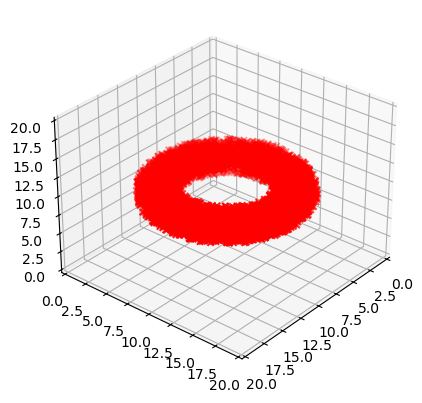

In [47]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(fps_torus[:, 0], fps_torus[:, 1], fps_torus[:, 2], marker='x', c='r', label='fps')
ax.view_init(30, 40)
plt.xlim(0, 20)
plt.ylim(0, 20)
ax.set_zlim(0, 20)
plt.show()

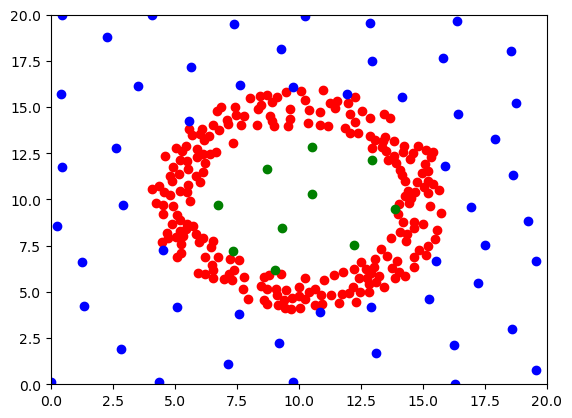

In [141]:
fps_ring = random_field_point_generator(2000, .25, [0, 20], [0,20], ring_boundary)
fps_far = random_field_point_generator(2000, 2, [0, 20], [0,20], far_field_boundary)
fps_center = random_field_point_generator(2000, 2, [0, 20], [0,20], ring_center_boundary)
plt.scatter(fps_ring[:, 0], fps_ring[:, 1], marker='o', c='r', label='ring')
plt.scatter(fps_far[:, 0], fps_far[:, 1], marker='o', c='b', label='far field')
plt.scatter(fps_center[:, 0], fps_center[:, 1], marker='o', c='g', label='center')
# plt.xlim(XBOUNDS[0]-5, XBOUNDS[1]+5)
# plt.ylim(YBOUNDS[0]-5, YBOUNDS[1]+5)
plt.xlim(XBOUNDS)
plt.ylim(YBOUNDS)
plt.show()

In [7]:
vel_num = vpcu.bs_solve(fps, vpps, vcrds, vcirs)

In [8]:
fpsvls = np.concatenate([fps, vel_num], axis=1)
np.savetxt('vrtx_ring_fps/vel_num.csv', fpsvls, delimiter=',', newline='\n')

In [9]:
fieldpoints = geo.Points(
    fps,
    vel=vel_num,
    display=dict(),
    metadata=dict()
)

fieldpoints.save(os.path.join(odir, 'fieldpoints.vtp'))

In [10]:
# def fps_gen(radius, numsegs):
#     fpsx = []
#     fpsy = []
#     # numsegs = 50
#     # radius = .65
#     for i in range(1, 10):
#         numfps1 = int(np.ceil(numsegs * (0.7 + i * 0.1)))
#         theta = np.linspace(0, 2 * np.pi, numfps1)
#         fpsx.append(radius * (1 + i * 0.1) * np.cos(theta))
#         fpsy.append(radius * (1 + i * 0.1) * np.sin(theta))

#     fpsx = np.concatenate(fpsx)
#     stride = len(fpsx)
#     fpsy = np.concatenate(fpsy)

#     fps = np.zeros((3 * stride, 3))
#     fps[:, 0] = np.tile(fpsx, 3)
#     fps[:, 1] = np.tile(fpsy, 3)

#     # z = np.linspace(-1, 1, 3)
#     # for i in range(len(z)-1):
#     #     fps1[stride*i:stride*(i+1), 2] = z[i]

#     return fps

# fps1 = fps_gen(0.65, 10)

# plt.scatter(fps1[:, 0], fps1[:, 1], marker='x', c='r', label='fps1')
# plt.plot(vpx, vpy, '.-', color='lightblue')
# plt.show()

In [11]:
# vel_num = bs_solve(fps, vpps, vcrds, vcirs)
# ax = plt.figure().add_subplot(projection='3d')
# ax.quiver(fps[:, 0], fps[:, 1], fps[:, 2], vel_num[:, 0], vel_num[:, 1], vel_num[:, 2], length=0.02, normalize=True, linewidth=0.5)
# ax.view_init(80, 30)
# plt.show()

In [12]:
# # # Generate the field points
# # x = np.linspace(-2, 2, NUMFP)
# # y = np.linspace(-2, 2, NUMFP)
# # # z = np.linspace(-2, 2, NUMFP)
# # # z = np.zeros_like(x)
# # z = np.array([0])
# # mgx, mgy, mgz = np.meshgrid(x, y, z)
# # fps = np.concatenate([mgx.flatten()[:, np.newaxis], mgy.flatten()[:, np.newaxis], mgz.flatten()[:, np.newaxis]], axis=1)
# # print('Shape of fps:', fps.shape)
# # # plt.scatter(fps[:, 0], fps[:, 1], marker='x', color='r')
# # # plt.show()


# # plt.imshow(vel_num[:, 2].reshape(NUMFP, NUMFP))
# levels = np.linspace(np.min(vel_num[:, 2]), np.max(vel_num[:, 2]), 7)
# plt.contourf(fps[:, 0], fps[:, 1], vel_num[:, 2], levels=levels, cmap='magma')
# plt.colorbar()
# plt.plot(vpx, vpy, '.-', color='lightblue')
# # plt.scatter(fps[:, 0], fps[:, 1], marker='x', color='r')
# plt.show()

In [5]:
# # NEED TO ADD Z COORDINATES
# def cylin_mesh(r1, r2, num_pts_per_rad_ary, zarray=[0]):
#     # nsegarray: array with length rsteps which
#     # specifies the number of segments for each
#     # radius step.

#     nrsteps = len(num_pts_per_rad_ary)
#     dr = (r2 - r1) / nrsteps

#     cymx = []
#     cymy = []

#     for i in range(0, nrsteps):
#         theta = np.linspace(0, 2 * np.pi, num_pts_per_rad_ary[i])
#         rad = (dr * i) + r1
#         # The phase is used to add some noise to the
#         # points. This is to prevent the points from
#         # being perfectly aligned.
#         phase = 0  # (np.pi / 3) * i
#         cymx.append(rad * np.cos(theta+phase))
#         cymy.append(rad * np.sin(theta+phase))

#     cymx = np.concatenate(cymx)
#     stride = len(cymx)
#     cymy = np.concatenate(cymy)

#     nzsteps = len(zarray)
#     cym = np.zeros((nzsteps * stride, 3))
#     cym[:, 0] = np.tile(cymx, nzsteps)
#     cym[:, 1] = np.tile(cymy, nzsteps)
#     cym[:, 2] = np.repeat(zarray, stride)

#     return cym

# # rpts = np.arange(15, 20)
# # fps = [cylin_mesh(7, 40, rpts)]
# fps = [cylin_mesh(0.1, 0.6, np.arange(4, 7), np.linspace(-1, 1, 20)),  # center of ring
#        cylin_mesh(0.7, 1.3, np.arange(20, 30), np.linspace(-2, 2, 20)),  # ring
#        cylin_mesh(1.7, 4, np.arange(15, 20), np.linspace(-10, 10, 20)),  # outside of ring (near)
#        cylin_mesh(7, 50, np.arange(15, 20), np.linspace(-40, 40, 20))]  # outside of ring (far)

# fps = np.concatenate(fps, axis=0)
# print('fps.shape:', fps.shape)

# plt.scatter(fps[:, 0], fps[:, 1], marker='x', c='r', label='fps')
# plt.plot(vpx, vpy, '.-', color='lightblue')
# # plt.xlim(-30, 30)
# # plt.ylim(-30, 30)
# plt.show()
